<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-2/state-schema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 状态模式（State Schema）

## 回顾

在第 1 模块中，我们打好了基础，构建了一个能够：

- `act（行动）`：让模型调用特定工具
- `observe（观察）`：将工具输出回传给模型
- `reason（推理）`：让模型基于工具输出进行推理，决定下一步（例如继续调用工具或直接回复）
- `persist state（持久化状态）`：使用内存检查点器支持可被中断的长对话

我们还演示了如何在本地通过 LangGraph Studio 运行，以及如何使用 LangGraph Cloud 部署。

## 目标

本模块将帮助你更深入地理解“状态（state）”与“记忆（memory）”。

首先，我们来回顾在 LangGraph 中定义状态模式的几种常见方式。

In [ ]:
%%capture --no-stderr
# %pip install --quiet -U langgraph
%pip install langgraph==0.6.7

## 模式说明（Schema）

在定义 LangGraph 的 `StateGraph` 时，我们需要一个[状态模式（state schema）](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)。

状态模式用于描述图中将要使用的数据结构与类型。
所有节点（nodes）都应当遵循并通过该模式进行通信。

---

在 LangGraph 中，**State Schema**（状态模式）是用于定义图的状态（state）或“记忆”（memory）的数据结构。它规定了在整个图的执行过程中，数据是如何在不同节点间共享和传递的。

简单来说，你可以将 State Schema 理解为一个字典（dict），其中每个键（key）代表一个特定的数据字段，而值（value）则存储该字段的实际数据。当图运行时，每个节点都可以访问、读取和更新这个共享的状态字典。

例如，一个简单的状态模式可能包含以下字段：

* `chat_history`: 用于存储用户和 Agent 之间的对话历史。
* `user_input`: 用于存储最新的用户输入。
* `tool_output`: 用于存储工具调用的结果。

通过使用 State Schema，LangGraph 能够实现：

* **跨节点的数据共享**: 不同的节点（如处理用户输入的节点、调用工具的节点、生成响应的节点）都能够访问同一个共享状态，从而实现数据的无缝传递。
* **短时/长时记忆**: 结合数据库（如 Postgres），State Schema 可以支持短时记忆（当前运行的状态）和长时记忆（跨多次运行持久化的状态）。
* **可控的执行流**: 边（edges）可以根据状态中的数据来决定下一步的执行路径，例如，如果 `tool_output` 中包含特定信息，就将控制流路由到另一个节点。

---

LangGraph 在定义状态模式方面非常灵活，既支持多种 Python 的[类型](https://docs.python.org/3/library/stdtypes.html#type-objects)，也支持不同的校验方式。

## TypedDict

正如在模块 1 中提到的，我们可以使用 Python `typing` 模块中的 `TypedDict`。

它允许你声明字典的键及其对应的值类型。

需要注意：这些只是“类型提示（type hints）”。

它们可用于静态类型检查器（例如 [mypy](https://github.com/python/mypy)）或 IDE 在运行前发现潜在的类型问题，

但在运行时并不会强制校验！

In [ ]:
# 说明：使用 TypedDict 定义最基础的“状态模式（State Schema）”
# 提示：TypedDict 只提供类型提示（静态检查），运行时不会强制校验类型
# 适用：入门理解“状态键=通道（channel）”的概念，每个键是一条状态通道
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    # 必填字符串键：foo（一条状态通道）
    foo: str
    # 必填字符串键：bar（另一条状态通道）
    bar: str

如果需要更严格的取值约束，可以使用 `Literal` 这样的类型提示。

例如，这里将 `mood` 的取值限制为 "happy" 或 "sad"。

In [ ]:
# 说明：通过 Literal 收紧取值范围（仍然是类型提示，运行时不强制）
# 这里将 mood 限定为 "happy" 或 "sad"，便于 IDE/静态检查提前发现潜在问题
from typing import Literal

class TypedDictState(TypedDict):
    # 用户名（字符串）
    name: str
    # 心情（仅允许 "happy" 或 "sad"）
    mood: Literal["happy","sad"]

在 LangGraph 中，我们可以将定义好的状态类（例如这里的 `TypedDictState`）直接传入 `StateGraph` 使用。

可以将每个状态键理解为图中的一条“通道（channel）”。

正如模块 1 所述：在每个节点中，我们会覆盖指定键（即通道）的值。

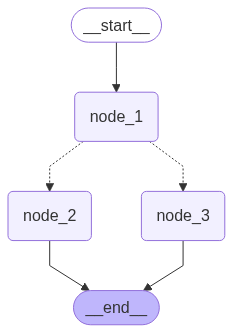

In [ ]:
# 演示：使用 TypedDictState 作为图的“状态模式”
# - 每个节点（node）返回一个子字典来“覆盖”对应的状态键（通道）
# - 这里有 3 个节点：node_1 修改 name；node_2/3 设置 mood
# - 通过条件边（conditional edges）在 node_2 与 node_3 之间二选一
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# 节点函数约定：输入是当前聚合后的 state，返回需要更新的键值对
# 注意：即便 state 是 TypedDict，节点返回值依旧是普通 dict（LangGraph 会按键合并）
def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

# 固定将 mood 置为 "happy"
def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

# 固定将 mood 置为 "sad"
def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

# 路由函数：根据当前 state 决定下一步走向哪个节点
# 返回值必须是已有节点名之一
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    # 这里做一个 50/50 的随机分流，用于演示条件边
    if random.random() < 0.5:
        return "node_2"  # 50% 进入 node_2
    return "node_3"      # 50% 进入 node_3

# 构建图（绑定状态模式）
builder = StateGraph(TypedDictState)
# 注册节点
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 配置边：从 START 到 node_1，然后按条件分流到 node_2 或 node_3，最后到 END
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# 编译得到可执行的图
graph = builder.compile()

# 可视化图结构（Mermaid 渲染）
display(Image(graph.get_graph().draw_mermaid_png()))

由于此处的状态是字典，我们可以直接以字典形式调用图，为状态中的 `name` 键设置初始值。

In [ ]:
# 调用：传入初始状态（dict 形式），只需给出需要初始化的键
# 这里仅初始化 name；mood 将由后续节点写入
graph.invoke({"name":"Lance"})

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

## Dataclass（数据类）

Python 的 [dataclasses](https://docs.python.org/3/library/dataclasses.html) 提供了[另一种定义结构化数据的方式](https://www.datacamp.com/tutorial/python-data-classes)。

Dataclass 提供简洁语法，适用于主要用于存放数据的类的定义。

In [ ]:
# 说明：使用 dataclasses 定义状态模式
# 提示：dataclass 一样只提供类型提示，运行时不强制校验
# 区别：访问键的方式从 state["name"] 变为 state.name
from dataclasses import dataclass
from typing import Literal

@dataclass
class DataclassState:
    # 用户名（字符串）
    name: str
    # 心情（仅允许 "happy" 或 "sad" 的类型提示）
    mood: Literal["happy","sad"]

要访问 `dataclass` 的字段，只需调整 `node_1` 中访问的方式：

- `dataclass` 状态使用 `state.name`，而前面的 `TypedDict` 使用 `state["name"]`

你可能会觉得奇怪：在每个节点中，我们依然返回一个普通字典来更新状态。

之所以可以这样做，是因为 LangGraph 会将状态对象的每个键单独存储。

节点返回的对象只需要包含与状态中键（属性）同名的项即可！

在这个例子中，`dataclass` 具有键 `name`，因此我们仍可通过节点返回的 dict 来更新它，这与使用 `TypedDict` 时的做法一致。

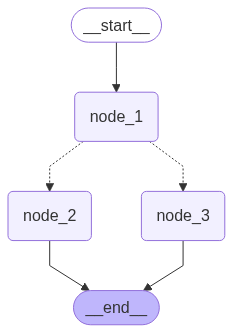

In [ ]:
# 与 TypedDict 版本唯一不同：在节点中以属性访问（state.name）读取值
# 返回值仍是普通 dict（按键合并更新）
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# 用 dataclass 版本的状态构建图
builder = StateGraph(DataclassState)
# 其余节点与边的配置复用之前定义的 node_2/node_3/decide_mood
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 边关系相同
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# 编译
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

我们可以直接传入一个 `dataclass` 实例来设置状态中各个键（通道）的初始值！

In [ ]:
# 调用：dataclass 作为初始状态对象，按字段名提供初始值
graph.invoke(DataclassState(name="Lance", mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

## Pydantic

如前所述，`TypedDict` 与 `dataclasses` 仅提供类型提示，并不会在运行时强制类型校验。

这意味着即使赋予了非法值，代码也可能不会报错！

例如，即便类型提示为 `mood: Literal["happy","sad"]`，你仍然可以将 `mood` 设为 `mad`，这在运行时并不会触发异常。

In [ ]:
# 演示：dataclass 不做运行时校验，因此这行不会抛错（但与类型提示冲突）
# 在大型应用中建议使用运行时校验（例如 Pydantic）保证数据质量
dataclass_instance = DataclassState(name="Lance", mood="mad")

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) 是一个基于 Python 类型注解的数据校验与配置管理库。

得益于其强大的校验能力，它非常适合用于 [在 LangGraph 中定义状态模式](https://langchain-ai.github.io/langgraph/how-tos/state-model/)。

Pydantic 能在运行时校验数据是否符合指定的类型与约束。

In [ ]:
# 说明：使用 Pydantic 定义状态模式（支持运行时校验）
# 优点：当输入数据不满足约束时，立即抛出 ValidationError，避免“脏数据”进入系统
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str  # 运行时将校验值必须在 {"happy", "sad"} 内

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # 运行时校验：确保 mood 只能是 "happy" 或 "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

# 演示：传入非法值将触发校验异常
try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error


我们可以将 `PydanticState` 无缝用于图中。

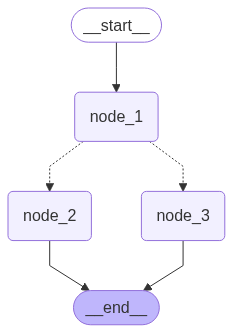

In [ ]:
# 使用 PydanticState 构建图（其余节点逻辑与前面一致）
# 好处：如果某个节点尝试写入非法值，Pydantic 会在运行时报错
builder = StateGraph(PydanticState)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# 编译并可视化
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 调用：将 PydanticState 作为初始状态对象传入（若入参非法会报错）
graph.invoke(PydanticState(name="Lance", mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}